# Exploring the two scalar fields model

In this notebook, I try to reproduce some figures from https://arxiv.org/abs/2211.13653. I will refer to equations and figures in the paper.

Author: João Victor Rebouças, March 2024

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Units: assume reduced natural units: $c = 8 \pi G = \hbar = 1$

In [2]:
# Value of rho_cr from https://pdg.lbl.gov/2015/reviews/rpp2015-rev-astrophysical-constants.pdf
# TODO: the units seem to be a bit off in Figure 2a
rho_cr_over_h2_in_gev4 = 1.053e-5 / (8065.544e9)**3

# Fixed parameters from Planck 2018
h = 0.6756
omega_c = 0.12/h**2
omega_b = 0.022/h**2
omega_phot = 2.47e-5/h**2
omega_massless_nu = 3*(7/8)*(4/11)**(4/3)*omega_phot
omega_r = omega_phot + omega_massless_nu
omega_de = 1 - omega_c - omega_b - omega_r

rho_cr = 3

## Equations:
The Klein-Gordon equation for $\phi$ with DM interaction is (see Equation 39):

$\phi'' + 2\mathcal{H}\phi' = -\frac{a^2\rho_\chi}{\phi}$

The idea is to split the second-order equation for $\phi$ into two first-order equations for $\phi$ and $\phi'$, with the independent variable being the scale factor $a$. We use the relation

$\frac{d}{d\tau} = \frac{da}{d\tau}\frac{d}{da} = a\mathcal{H}\frac{d}{da}$

to rewrite the Klein-Gordon equation as:

$\frac{d\phi}{da} = \frac{\phi'}{a\mathcal{H}}$

$\frac{d\phi'}{da} = -2\frac{\phi'}{a} - \frac{a\rho_\chi}{\mathcal{H}\phi}$

In [23]:
def H_curly(y: list[float], a: float, V0: float, rho_dm: float) -> float:
	_, phi_prime = y
	rho_phi = phi_prime**2/(2*a**2) + V0
	rho = rho_cr*(omega_r*a**(-4) + omega_b*a**(-3)) + rho_dm + rho_phi
	return a*np.sqrt(rho/3)

def equations(y: list[float], a: float, V0: float, rho_dm_i: float, a_i: float, phi_i: float) -> list[float]:
	phi, phi_prime = y
	rho_dm = rho_dm_i*(phi/phi_i)*(a_i/a)**3
	H = H_curly(y, a, V0, rho_dm)
	dphi = phi_prime/(a*H)
	dphi_prime = -2*phi_prime/a - a*rho_dm/(phi*H)
	return np.array([dphi, dphi_prime])

def equations_loga(y: list[float], loga: float, V0: float, rho_dm_i: float, a_i: float, phi_i: float) -> list[float]:
	a = np.exp(loga)
	derivs = equations(y, a, V0, rho_dm_i, a_i, phi_i)
	return a*derivs

def integrate_cosmo(ic: list[float], a_ini: float, a_end: float, n_steps: int, V0: float, rho_dm_i: float) -> list[list[float], list[float]]:
	# Integrates first with respect to log(a)
	frac = 0.4 # The user provides the total number of time steps, `frac` is the fraction of time-steps spent in log integration
	a_treshold = 1e-3 # Scale factor to switch between log integration and normal integration
	phi_i = ic[0]
	n_steps_log = int(frac*n_steps)
	a_log = np.logspace(np.log10(a_ini), np.log10(a_treshold), n_steps_log)
	loga = np.log(a_log)
	result_log = odeint(equations_loga, ic, loga, args=(V0, rho_dm_i, a_ini, phi_i))
	ic_normal_integration = result_log[-1] # Initial conditions of normal integration is final state of log integration
	a = np.linspace(a_treshold, a_end, n_steps-n_steps_log)
	result_normal = odeint(equations, ic_normal_integration, a, args=(V0, rho_dm_i, a_ini, phi_i))
	return np.concatenate((a_log, a)), np.concatenate((result_log, result_normal))

def find_fracs_de_dm_0(result, V0, rho_dm_0):
	_, phi_prime = result.T
	rho_phi_0 = phi_prime[-1]**2/2 + V0
	rho_tot = rho_cr*(omega_r + omega_b) + rho_dm_0 + rho_phi_0
	return rho_phi_0/rho_cr, rho_dm_0/rho_cr

def solve_system(ic, a_ini, a_end, n_steps):
	print("-----")
	phi_i = ic[0]
	print(f"Begin shooting for phi_i = {phi_i}")
	print(f"Target omega_de: {omega_de:.6f}; Target omega_c = {omega_c:.6f}")

	# Initial guesses for shooting parameters
	V0_1 = 1.15*rho_cr*omega_de
	V0_2 = 0.9*rho_cr*omega_de

	# Notice that the initial_guess for rho_dm_i assumes no (phi/phi_i) factor
	rho_dm_i_guess = rho_cr*omega_c*a_ini**(-3)
	rho_dm_i = rho_dm_i_guess
	
	# Integrate KG with initial guesses
	a, result_1 = integrate_cosmo(ic, a_ini, a_end, n_steps, V0_1, rho_dm_i)
	a, result_2 = integrate_cosmo(ic, a_ini, a_end, n_steps, V0_2, rho_dm_i)
	
	# Correct missing phi/phi_i factor
	# TODO: understand why this works
	phi_0_1 = result_1.T[0][-1]
	phi_0_2 = result_1.T[0][-1]
	rho_dm_i = rho_dm_i_guess*(phi_i/phi_0_1)
	
	# Evaluate omega_c and omega_de for initial guesses
	rho_dm_0_1 = rho_dm_i*(phi_0_1/phi_i)*(a_ini)**3
	rho_dm_0_2 = rho_dm_i*(phi_0_2/phi_i)*(a_ini)**3

	omega_de_1, omega_c_1 = find_fracs_de_dm_0(result_1, V0_1, rho_dm_0_1)
	omega_de_2, omega_c_2 = find_fracs_de_dm_0(result_2, V0_2, rho_dm_0_2)
	
	# Assess errors at initial guesses
	error_dm_1 = (omega_c_1 - omega_c)/omega_c
	error_dm_2 = (omega_c_2 - omega_c)/omega_c
	error_de_1 = (omega_de_1 - omega_de)/omega_de
	error_de_2 = (omega_de_2 - omega_de)/omega_de

	print(f"V0 = {V0_1:.6f} => omega_de = {omega_de_1:.6f} (error = {error_de_1:.6f}); omega_c = {omega_c_1:.6f} (error = {error_dm_1:.6f})")
	print(f"V0 = {V0_2:.6f} => omega_de = {omega_de_2:.6f} (error = {error_de_2:.6f}); omega_c = {omega_c_2:.6f} (error = {error_dm_2:.6f})")

	# TODO: Secant method does not require initial guesses to enclose solution
	encapsulating = (omega_de_1 - omega_de)*(omega_de_2 - omega_de) < 0
	if not encapsulating:
		print("WARNING: initial guesses for V0 did not encapsulate the target omega_de")
		print(f"Target omega_de: {omega_de}")
		print(f"V0 = {V0_1:.6f} => omega_de = {omega_de_1:.6f}")
		print(f"V0 = {V0_2:.6f} => omega_de = {omega_de_2:.6f}")
	
	iters = 0
	max_iters = 20
	while (iters < max_iters):
		iters += 1

		# Fit a line between (V0_1, omega_de_1) and (V0_2, omega_de_2)
		a_line = (omega_de_2 - omega_de_1)/(V0_2 - V0_1)
		b_line = omega_de_2 - a_line*V0_2

		# Choose the point where the line would cross the target omega_de
		V0_try = (omega_de - b_line)/a_line

		# Integrate KG assuming this new V0
		a, result_try = integrate_cosmo(ic, a_ini, a_end, n_steps, V0_try, rho_dm_i)
		phi_0_try = result_try.T[0][-1]
		
		# Evaluate omega_de and omega_c for new point
		rho_dm_0_try = rho_dm_i*(phi_0_try/phi_i)*(a_ini)**3
		omega_de_try, omega_c_try = find_fracs_de_dm_0(result_try, V0_try, rho_dm_0_try)
		
		# Assess errors at new point
		error = (omega_de_try - omega_de)/omega_de
		error_omega_c = (omega_c_try - omega_c)/omega_c
		print(f"V0 = {V0_try:.6f} => omega_de = {omega_de_try:.6f} (error = {error:.6f}); omega_c = {omega_c_try:.6f} (error = {error_omega_c:.6f})")
		
		# Update rho_dm_i
		rho_dm_i = rho_dm_i_guess*(phi_i/result_try.T[0][-1])
		
		# Exit condition
		if abs(error) < 1e-4: break

		# Substitute one of the initial V0 guesses by the new V0 guess
		if (omega_de_try > omega_de):
			V0_1 = V0_try
			omega_de_1 = omega_de_1
		else:
			V0_2 = V0_try
			omega_de_2 = omega_de_2
		
	if error > 1e-4:
		print(f"WARNING: reached max iterations in shooting with error = {error}")
	else:
		print(f"Finished shooting successfully after {iters} iterations")
	return a, result_try, V0_try, rho_dm_i

In [24]:
# Getting results
a_ini = 1e-14
n_steps = 10_000

phi_i = 8
ic = [phi_i, 0]
a, result_8, V0_8, rho_dm_i_8 = solve_system(ic, a_ini, 1, n_steps)

phi_i = 10
ic = [phi_i, 0]
a, result_10, V0_10, rho_dm_i_10 = solve_system(ic, a_ini, 1, n_steps)

phi_i = 15
ic = [phi_i, 0]
a, result_15, V0_15, rho_dm_i_15 = solve_system(ic, a_ini, 1, n_steps)

phi_i = 20
ic = [phi_i, 0]
a, result_20, V0_20, rho_dm_i_20 = solve_system(ic, a_ini, 1, n_steps)

-----
Begin shooting for phi_i = 8
Target omega_de: 0.688803; Target omega_c = 0.262907
V0 = 2.376369 => omega_de = 0.793698 (error = 0.152287); omega_c = 0.262907 (error = 0.000000)
V0 = 1.859767 => omega_de = 0.621631 (error = -0.097520); omega_c = 0.262907 (error = 0.000000)
V0 = 2.061438 => omega_de = 0.689489 (error = 0.000997); omega_c = 0.257130 (error = -0.021974)
V0 = 1.938495 => omega_de = 0.648630 (error = -0.058323); omega_c = 0.262263 (error = -0.002450)
V0 = 1.986490 => omega_de = 0.664619 (error = -0.035110); omega_c = 0.262899 (error = -0.000029)
V0 = 2.015748 => omega_de = 0.674361 (error = -0.020966); omega_c = 0.262936 (error = 0.000111)
V0 = 2.033585 => omega_de = 0.680300 (error = -0.012344); omega_c = 0.262928 (error = 0.000079)
V0 = 2.044458 => omega_de = 0.683920 (error = -0.007088); omega_c = 0.262920 (error = 0.000049)
V0 = 2.051087 => omega_de = 0.686127 (error = -0.003884); omega_c = 0.262915 (error = 0.000030)
V0 = 2.055128 => omega_de = 0.687473 (error = -

In [25]:
# Calculating densities for each case
rho_r_a = rho_cr*omega_r * a**(-4)
rho_b_a = rho_cr*omega_b * a**(-3)
rho_dm_a_lcdm = rho_cr*omega_c * a**(-3)
rho_de_a_lcdm = rho_cr*(1-omega_c-omega_b-omega_r)*np.ones((n_steps))

phi_a_8, phi_prime_a_8 = result_8.T
phi_a_10, phi_prime_a_10 = result_10.T
phi_a_15, phi_prime_a_15 = result_15.T
phi_a_20, phi_prime_a_20 = result_20.T

rho_de_a_8 = phi_prime_a_8**2/(2*a**2) + V0_8
rho_de_a_10 = phi_prime_a_10**2/(2*a**2) + V0_10
rho_de_a_15 = phi_prime_a_15**2/(2*a**2) + V0_15
rho_de_a_20 = phi_prime_a_20**2/(2*a**2) + V0_20

rho_dm_a_8 = rho_dm_i_8*(phi_a_8/8)*(a_ini/a)**3
rho_dm_a_10 = rho_dm_i_10*(phi_a_10/10)*(a_ini/a)**3
rho_dm_a_15 = rho_dm_i_15*(phi_a_15/15)*(a_ini/a)**3
rho_dm_a_20 = rho_dm_i_20*(phi_a_20/20)*(a_ini/a)**3

In [38]:
# Calculating energy density fractions
rho_tot_a_8 = rho_r_a + rho_b_a + rho_dm_a_8 + rho_de_a_8
rho_tot_a_10 = rho_r_a + rho_b_a + rho_dm_a_10 + rho_de_a_10
rho_tot_a_15 = rho_r_a + rho_b_a + rho_dm_a_15 + rho_de_a_15
rho_tot_a_20 = rho_r_a + rho_b_a + rho_dm_a_20 + rho_de_a_20
rho_tot_a_lcdm = rho_r_a + rho_b_a + rho_dm_a_lcdm + rho_de_a_lcdm

f_r_a_8 = rho_r_a/rho_tot_a_8
f_r_a_10 = rho_r_a/rho_tot_a_10
f_r_a_lcdm = rho_r_a/rho_tot_a_lcdm
f_b_a_8 = rho_b_a/rho_tot_a_8
f_b_a_10 = rho_b_a/rho_tot_a_10
f_b_a_lcdm = rho_b_a/rho_tot_a_lcdm
f_dm_a_8 = rho_dm_a_8/rho_tot_a_8
f_dm_a_10 = rho_dm_a_10/rho_tot_a_10
f_dm_a_lcdm = rho_dm_a_lcdm/rho_tot_a_lcdm
f_de_a_8 = rho_de_a_8/rho_tot_a_8
f_de_a_10 = rho_de_a_10/rho_tot_a_10
f_de_a_lcdm = rho_de_a_lcdm/rho_tot_a_lcdm

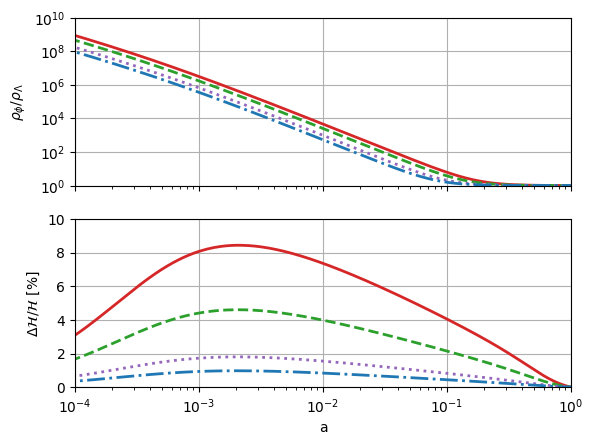

In [50]:
# Plot phi energy density and delta H
H_lcdm = a*np.sqrt(rho_tot_a_lcdm/3)
H_8 = a*np.sqrt(rho_tot_a_8/3)
H_10 = a*np.sqrt(rho_tot_a_10/3)
H_15 = a*np.sqrt(rho_tot_a_15/3)
H_20 = a*np.sqrt(rho_tot_a_20/3)

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
# Plot phi energy density and delta H
axs[0].loglog(a, rho_de_a_8/rho_de_a_lcdm, color='tab:red', ls='-', lw=2)
axs[0].loglog(a, rho_de_a_10/rho_de_a_lcdm, color='tab:green', ls='--', lw=2)
axs[0].loglog(a, rho_de_a_15/rho_de_a_lcdm, color='tab:purple', ls=':', lw=2)
axs[0].loglog(a, rho_de_a_20/rho_de_a_lcdm, color='tab:blue', ls='-.', lw=2)
axs[0].set_xlim([1e-4, 1])
axs[0].set_ylim([1, 1e10])

axs[1].semilogx(a, 100*(H_8 - H_lcdm)/H_lcdm, color='tab:red', ls='-', lw=2)
axs[1].semilogx(a, 100*(H_10 - H_lcdm)/H_lcdm, color='tab:green', ls='--', lw=2)
axs[1].semilogx(a, 100*(H_15 - H_lcdm)/H_lcdm, color='tab:purple', ls=':', lw=2)
axs[1].semilogx(a, 100*(H_20 - H_lcdm)/H_lcdm, color='tab:blue', ls='-.', lw=2)

plt.ylim([0, 10])

axs[1].set_xlabel("a")
axs[0].set_ylabel(r"$\rho_\phi/\rho_\Lambda$")
axs[1].set_ylabel(r"$\Delta \mathcal{H}/\mathcal{H}$ [%]")
axs[0].grid()
axs[1].grid()
plt.savefig("fig1_b.pdf")

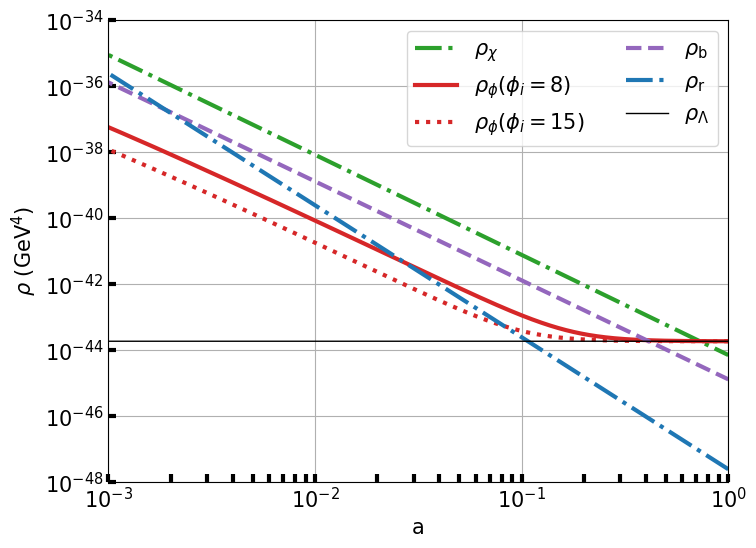

In [26]:
# Plot densities (Figure 2a)
rho_cr_in_gev4 = rho_cr_over_h2_in_gev4 * h**2
plt.figure(figsize=(8,6))
plt.loglog(a, rho_cr_in_gev4*rho_dm_a_8, color='tab:green', ls='-.', lw=3, label=r"$\rho_\chi$")
plt.loglog(a, rho_cr_in_gev4*rho_de_a_8, color='tab:red', ls='-', lw=3, label=r"$\rho_\phi (\phi_i = 8)$")
plt.loglog(a, rho_cr_in_gev4*rho_de_a_15, color='tab:red', ls=':', lw=3, label=r"$\rho_\phi (\phi_i = 15)$")
plt.loglog(a, rho_cr_in_gev4*rho_b_a, color='tab:purple', ls='--', lw=3, label=r"$\rho_\mathrm{b}$")
plt.loglog(a, rho_cr_in_gev4*rho_r_a, color='tab:blue', ls='-.', lw=3, label=r"$\rho_\mathrm{r}$")
plt.loglog(a, rho_cr_in_gev4*rho_de_a_lcdm, color='black', ls='-', lw=1, label=r"$\rho_\Lambda$")

plt.xlim([1e-3, 1])
plt.ylim([1e-48, 1e-34])

plt.xlabel("a", fontsize=15)
plt.ylabel(r"$\rho$ ($\mathrm{GeV}^4$)", fontsize=15)

plt.tick_params(axis="both", which="both", direction="in", length=6, width=3)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.grid()
plt.legend(fontsize=15, ncol=2)

plt.savefig("fig2_a.pdf")

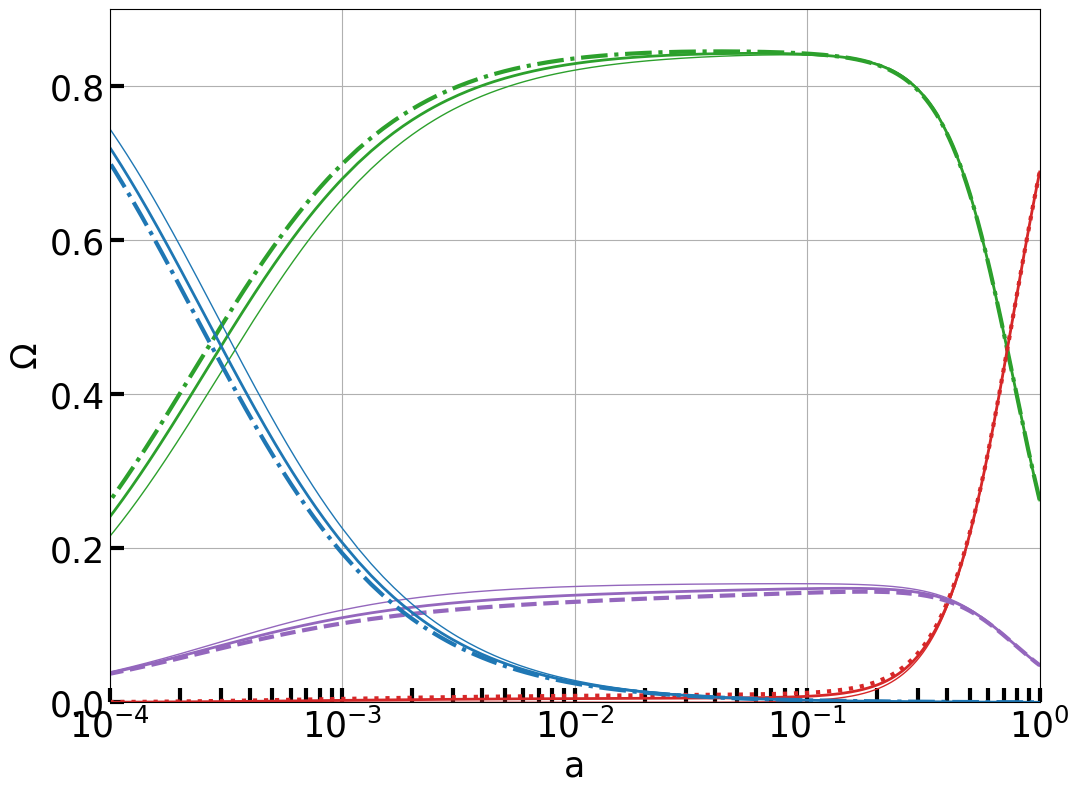

In [28]:
# Figure 1a
factor=3
plt.figure(figsize=(4*factor,3*factor))
plt.semilogx(a, f_dm_a_8, color='tab:green', ls='-.', lw=3)
plt.semilogx(a, f_dm_a_10, color='tab:green', ls='-', lw=2)
plt.semilogx(a, f_dm_a_lcdm, color='tab:green', ls='-', lw=1)
plt.semilogx(a, f_de_a_8, color='tab:red', ls=':', lw=3)
plt.semilogx(a, f_de_a_10, color='tab:red', ls='-', lw=2)
plt.semilogx(a, f_de_a_lcdm, color='tab:red', ls='-', lw=1)
plt.semilogx(a, f_b_a_8, color='tab:purple', ls='--', lw=3)
plt.semilogx(a, f_b_a_10, color='tab:purple', ls='-', lw=2)
plt.semilogx(a, f_b_a_lcdm, color='tab:purple', ls='-', lw=1)
plt.semilogx(a, f_r_a_8, color='tab:blue', ls='-.', lw=3)
plt.semilogx(a, f_r_a_10, color='tab:blue', ls='-', lw=2)
plt.semilogx(a, f_r_a_lcdm, color='tab:blue', ls='-', lw=1)
plt.xlim([1e-4, 1])
plt.ylim([0, 0.9])

plt.xlabel("a", fontsize=25)
plt.ylabel(r"$\Omega$", fontsize=25)
plt.tick_params(axis="both", which="both", direction="in", length=10, width=3)

plt.yticks([0.2*i for i in range(5)], fontsize=25)
plt.xticks(fontsize=25)

plt.grid()

plt.savefig("fig1_a.pdf")

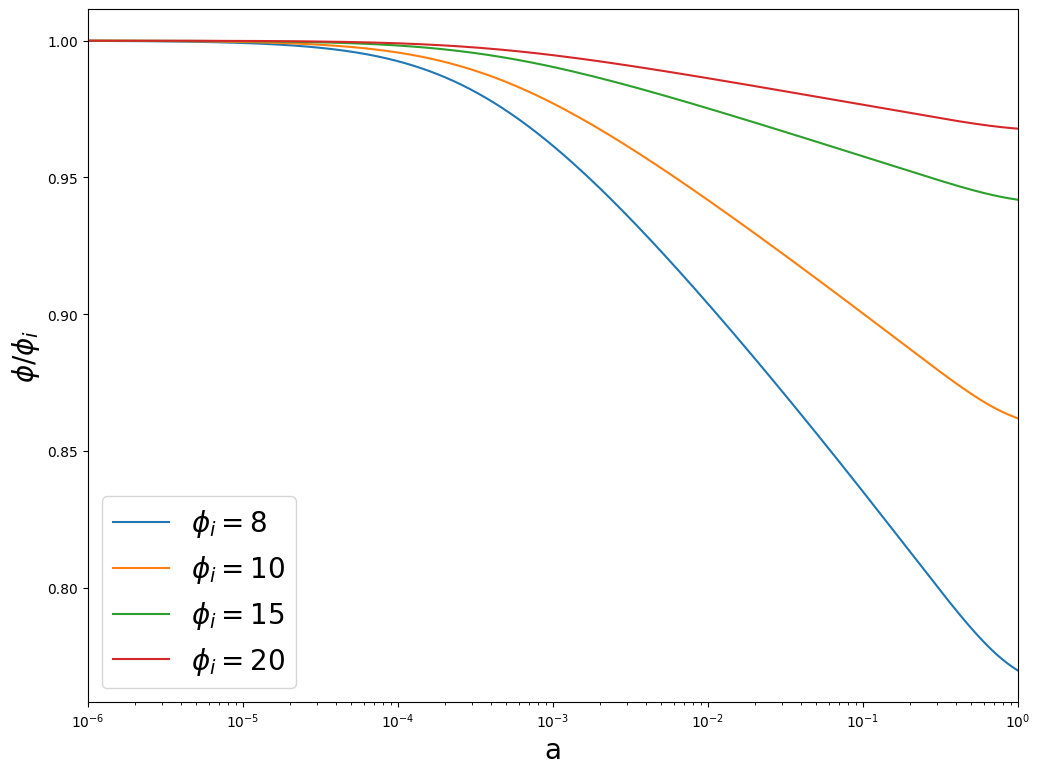

In [29]:
# Plotting phi(a)
factor=3
plt.figure(figsize=(4*factor,3*factor))

plt.semilogx(a, phi_a_8/8, label=r'$\phi_i = 8$')
plt.semilogx(a, phi_a_10/10, label=r'$\phi_i = 10$')
plt.semilogx(a, phi_a_15/15, label=r'$\phi_i = 15$')
plt.semilogx(a, phi_a_20/20, label=r'$\phi_i = 20$')

plt.xlabel("a", fontsize=20)
plt.ylabel(r"$\phi/\phi_i$", fontsize=20)

plt.xlim([1e-6, 1])

plt.legend(fontsize=20)

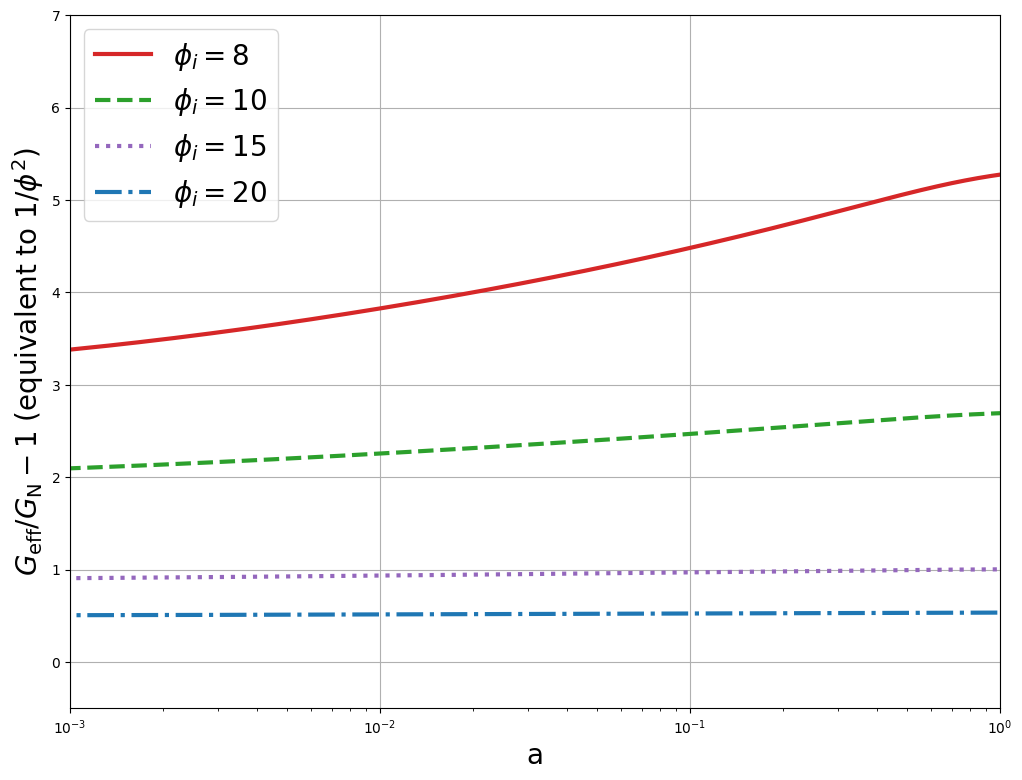

In [30]:
# Plotting G_eff/G_N - 1 ( = 1/phi^2) (Figure 2b)
factor=3
plt.figure(figsize=(4*factor,3*factor))

plt.semilogx(a, 100*2/(phi_a_8)**2, color="tab:red", ls="-", lw=3, label=r'$\phi_i = 8$')
plt.semilogx(a, 100*2/(phi_a_10)**2, color="tab:green", ls="--", lw=3, label=r'$\phi_i = 10$')
plt.semilogx(a, 100*2/(phi_a_15)**2, color="tab:purple", ls=":", lw=3, label=r'$\phi_i = 15$')
plt.semilogx(a, 100*2/(phi_a_20)**2, color="tab:blue", ls="-.", lw=3, label=r'$\phi_i = 20$')

plt.xlabel("a", fontsize=20)
plt.ylabel(r"$G_\mathrm{eff}/G_\mathrm{N} - 1$ (equivalent to $1/\phi^2$)", fontsize=20)

plt.xlim([1e-3, 1])
plt.ylim([-0.5, 7])

plt.legend(fontsize=20)
plt.grid()

plt.savefig("fig2_b.pdf")